<div style="font-size:22pt; line-height:25pt; font-weight:bold; text-align:center;">Classification de joueurs NBA</div>

In [9]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import VotingClassifier
from typing import final
from sklearn.ensemble import BaggingClassifier
from flask import Flask, request, jsonify
import pickle
from flask import render_template

from cmath import inf
from torch import positive
from collections import Counter

# Load dataset
df = pd.read_csv("nba_database.csv")

# Fonction de scoring donnée dans l'énoncé

Modifications apportées à la fonction de scoring / affichage de la matrice de confusion : <newline>
- Affichage du pourcentage de prédictions correctes et incorrectes par ligne dans la matrice de confusion. Un modèle parfait tendrait idéalement vers la matrice identité.

In [82]:
def score_classifier(dataset,classifier,labels,nb_splits=3):
    
    sup, inf = Counter(labels)[1], Counter(labels)[0]
  
    kf = KFold(n_splits=nb_splits,random_state=50,shuffle=True)
    confusion_mat = np.zeros((2,2))
    recall = 0
    for training_ids,test_ids in kf.split(dataset):
        training_set = dataset[training_ids]
        training_labels = labels[training_ids]
        test_set = dataset[test_ids]
        test_labels = labels[test_ids]
        classifier.fit(training_set,training_labels)
        predicted_labels = classifier.predict(test_set)
        confusion_mat+=confusion_matrix(test_labels,predicted_labels)
        recall += recall_score(test_labels, predicted_labels)
    recall/=nb_splits

    # confusion matrix with percentage on rows
    confusion_mat2 = confusion_mat.astype('float') / confusion_mat.sum(axis=1)[:, np.newaxis]
    print("Ratio btw true positives and false positives: ", confusion_mat2[1][1]/confusion_mat2[0][1])
    sns.heatmap(pd.DataFrame(confusion_mat2),annot=True,cmap="YlGnBu" ,fmt='g')
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('True')
    plt.xlabel('Predicted')
    return recall

In [3]:
# extract names, labels, features names and values
names = df['Name'].values.tolist() # players names
labels = df['TARGET_5Yrs'].values # labels
paramset = df.drop(['TARGET_5Yrs','Name'],axis=1).columns.values
df_vals = df.drop(['TARGET_5Yrs','Name'],axis=1).values

# replacing Nan values (only present when no 3 points attempts have been performed by a player)
for x in np.argwhere(np.isnan(df_vals)):
    df_vals[x]=0.0

# normalize dataset
X = MinMaxScaler().fit_transform(df_vals)

# Visualisation des données

,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,...,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0.0
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,...,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0.0
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,...,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0.0
3,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,...,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1.0
4,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,...,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1.0


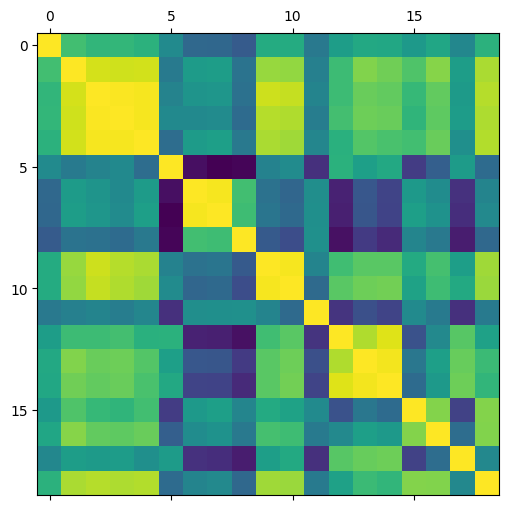

In [10]:
corr = df[paramset].corr()

# plot correlation matrix with colors
fig, ax = plt.subplots(figsize=(6,6))

ax.matshow(corr)

df['TARGET_5Yrs'].value_counts()
df.head()

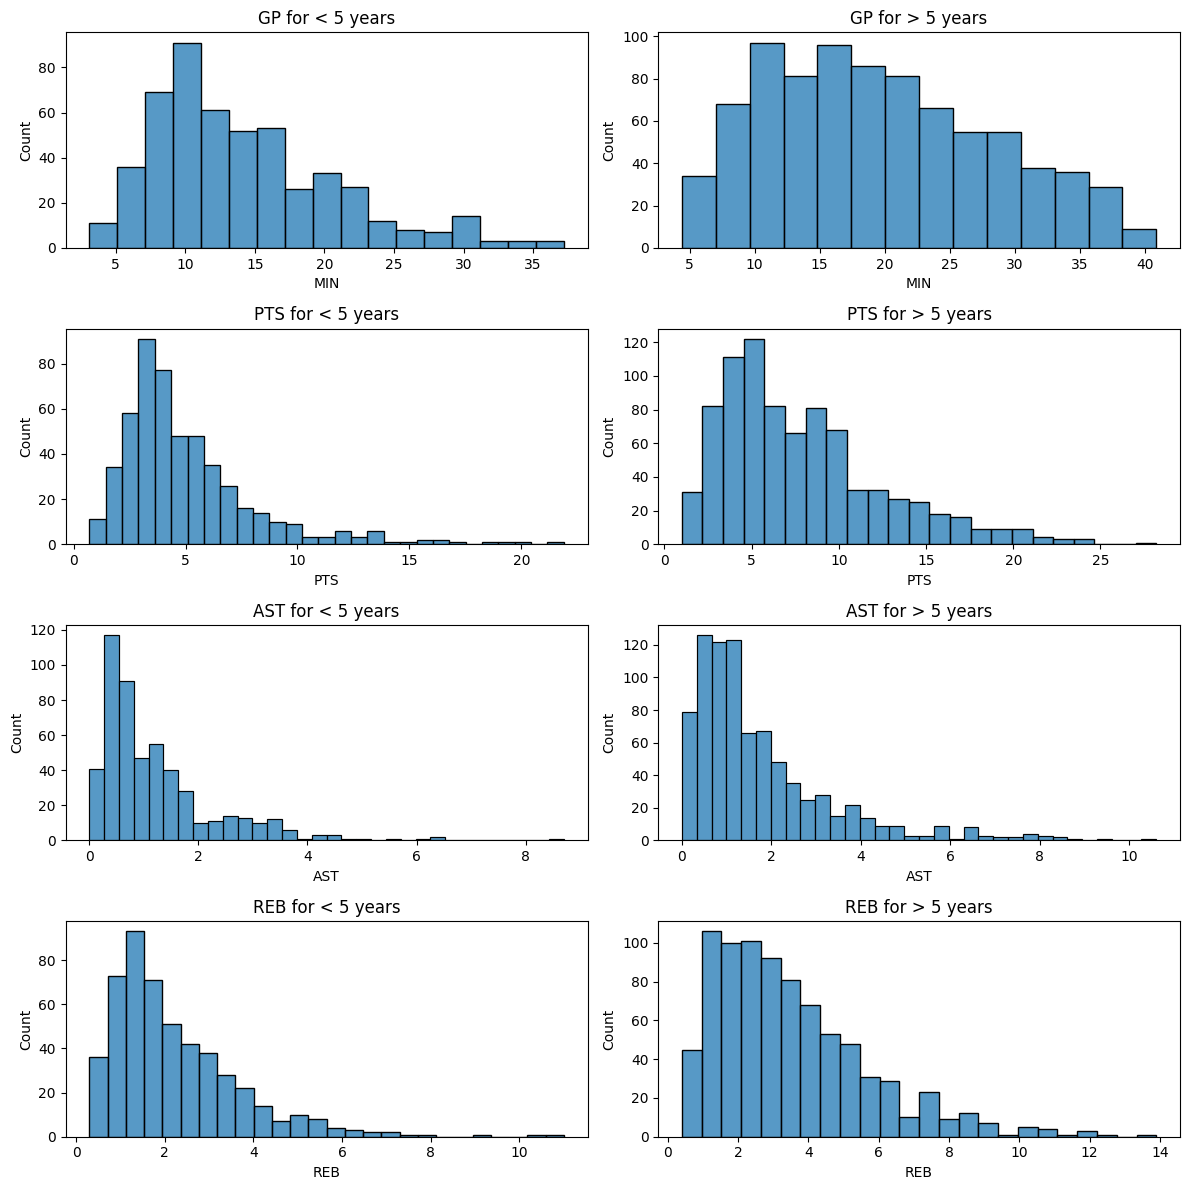

In [21]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 12))
ax = sns.histplot(df[df['TARGET_5Yrs']==0].MIN, ax=axes[0][0], kde =False)
ax.set_title('GP for < 5 years')
ax = sns.histplot(df[df['TARGET_5Yrs']==1].MIN, ax=axes[0][1], kde =False)
ax.set_title('GP for > 5 years')
ax = sns.histplot(df[df['TARGET_5Yrs']==0].PTS, ax=axes[1][0], kde =False)
ax.set_title('PTS for < 5 years')
ax = sns.histplot(df[df['TARGET_5Yrs']==1].PTS, ax=axes[1][1], kde =False)
ax.set_title('PTS for > 5 years')
ax = sns.histplot(df[df['TARGET_5Yrs']==0].AST, ax=axes[2][0], kde =False)
ax.set_title('AST for < 5 years')
ax = sns.histplot(df[df['TARGET_5Yrs']==1].AST, ax=axes[2][1], kde =False)
ax.set_title('AST for > 5 years')
ax = sns.histplot(df[df['TARGET_5Yrs']==0].REB, ax=axes[3][0], kde =False)
ax.set_title('REB for < 5 years')
ax = sns.histplot(df[df['TARGET_5Yrs']==1].REB, ax=axes[3][1], kde =False)
ax.set_title('REB for > 5 years')
plt.tight_layout()

Fortes correlations : 
1,2,3,4 (MinutesPlayed, PointsPerGame, FieldGoalsMade, FieldGoalAssists) / 12,13,14 (OffensiveRebounds, DefensiveRebounds, Rebounds)

# Premières décisions pour le choix du classifieur

Le dataset contient moins de 100k données ; j'ai remarqué des dépendances linéaires entre les features, qui sont d'ailleurs toutes des variables quantitatives. Par conséquent, les méthodes basées sur des arbres de décision ne sont pas adaptées à ce problème (j'ai fait quelques tests pour être sûr de cette décision et le score était assez mauvais pour les random forests par rapport à SVC).

Dans cette étude, le client souhaite investir dans un joueur qui va signer un contrat de 5 ans. On peut donc considérer que le modèle qui maximise le recall est le meilleur modèle. 

# Classification

# SVC

Détermination du C optimal pour le Support Vector Classifier (maximisant le score). On obtient $C_{opt} = 1.9$

In [ ]:

list_c = np.linspace(0.1, 20, 100)
list_score = []
for c in list_c:
    clf = SVC(C=c,kernel='rbf')
    list_score.append(score_classifier(X,clf,labels)) 

plt.figure(figsize=(10,5))
plt.title('SVM score function of C')
plt.xlabel('C')
plt.ylabel('Score')
plt.plot(list_c,list_score)

c_opt = list_c[np.argmax(list_score)]

print("C optimal = "+ str(c_opt))
print("Optimal score = "+ str(np.max(list_score)))

# PCA

In [8]:
pca = PCA(n_components=3)

pca.fit(X)

#plt.bar(range(X.shape[1]), pca.explained_variance_ratio_, color="r", align="center")

# print the cumulative sum of the explained variance ratio of the 2 first components

print(np.sum(pca.explained_variance_ratio_[0:3]))

X_pca = pca.transform(X)

# plt.figure(figsize=(10,5))
# plt.title('PCA')
# plt.xlabel('PC1')
# plt.ylabel('PC2')
# plt.scatter(X_pca[:,0],X_pca[:,1],c=labels)


0.7964511719862709


L'Analyse en Composantes Principales (ACP) n'est pas adaptée à ce problème, car la variance cumulée des 3 premières composantes est trop faible pour représenter le dataset (environ 79%).

# K-Nearest Neighbours

Nombre optimal de nombre de proches voisins : 15 (testé au préalable)

Ratio btw true positives and false positives:  1.6407531449504396


0.80275989918204

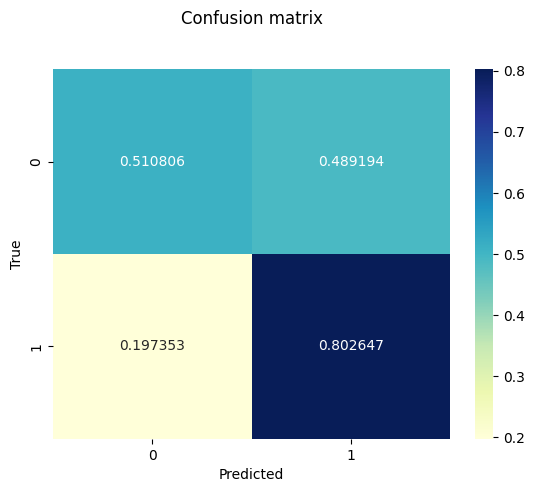

In [83]:
# k-nearest neighbors classification

model_knn = KNeighborsClassifier(n_neighbors=15)

score_classifier(X,model_knn,labels,nb_splits=3)


Ratio btw true positives and false positives:  1.7250423635158034
0.8304428871428234


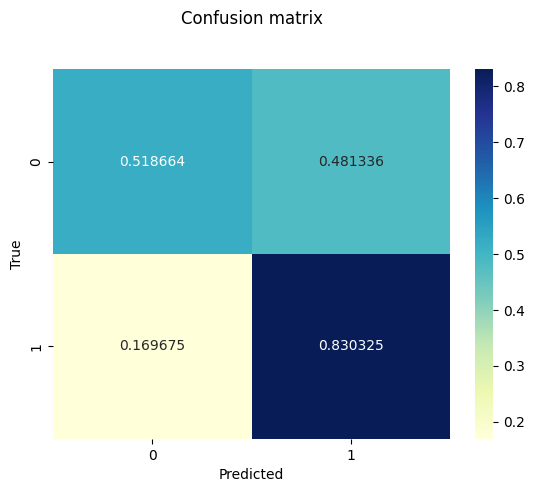

In [84]:

model_SVC = SVC(C=1.9,kernel='rbf',probability=True)

print(score_classifier(X,model_SVC,labels,nb_splits=3))


Ratio btw true positives and false positives:  1.7071704386740703
0.8351030883971994


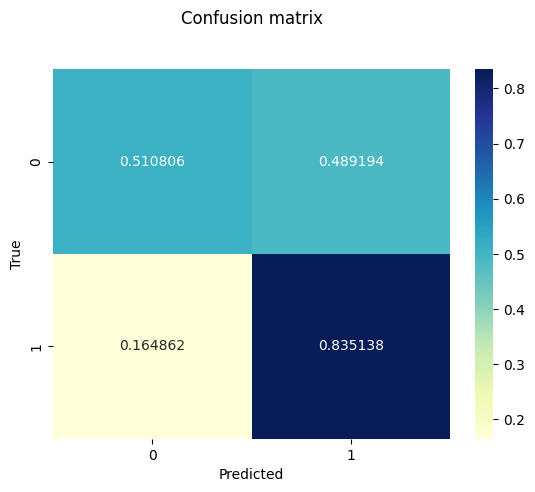

In [85]:
model_lr = LogisticRegression()

print(score_classifier(X,model_lr,labels,nb_splits=3))

# Voting Classifier

Essaie de Voting

Ratio btw true positives and false positives:  1.6899511403012772
0.8267442957929262


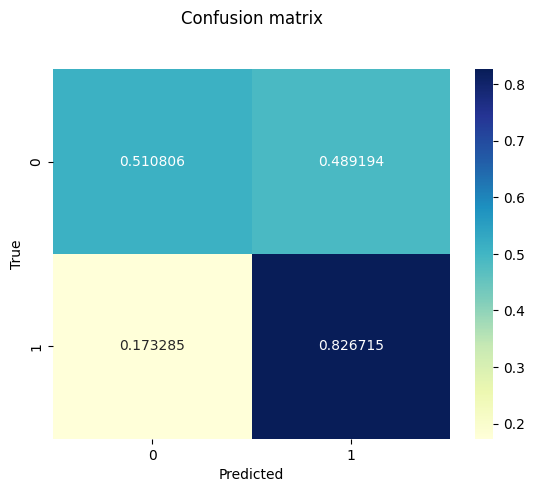

In [86]:
# create a voting classifier

eclf = VotingClassifier(estimators=[('knn', model_knn), ('lr', model_lr), ('svc', model_SVC)], voting='soft')

print(score_classifier(X,eclf,labels,nb_splits=3))

# Bagging 

Ratio btw true positives and false positives:  1.6954416365824307
0.8325217367075872


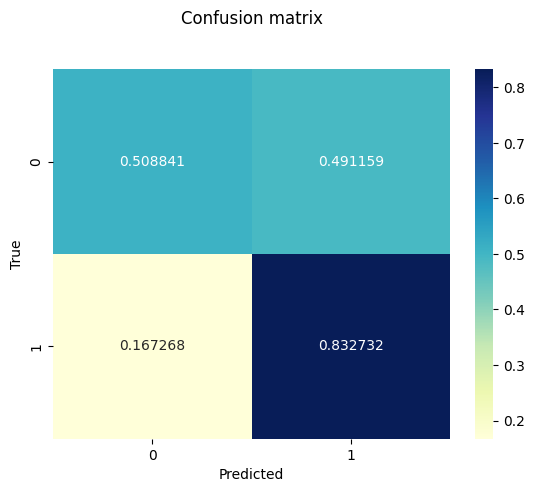

In [101]:
# bagging classifier

bagging = BaggingClassifier(base_estimator=model_lr,n_estimators=4,random_state=10,bootstrap=True)
print(score_classifier(X,bagging,labels,nb_splits=3))


# Using XGBoost

L'intuition initiale est que l'utilisation de modèles basés sur les arbres de décision ne conviendrait pas à ce problème. Je teste néanmoins XGBoost pour m'en assurer.

Ratio btw true positives and false positives:  1.7217334587264508
0.8049920252300935
    feature  importance
0        GP    0.181075
3       FGM    0.123568
12     OREB    0.067376
5       FG%    0.065524
7       3PA    0.064150
14      REB    0.053482
13     DREB    0.045998
9       FTM    0.042068
17      BLK    0.040347
15      AST    0.039792
4       FGA    0.039518
8       3P%    0.037278
11      FT%    0.036729
18      TOV    0.036193
1       MIN    0.032952
2       PTS    0.029766
6   3P Made    0.026071
16      STL    0.020065
10      FTA    0.018046


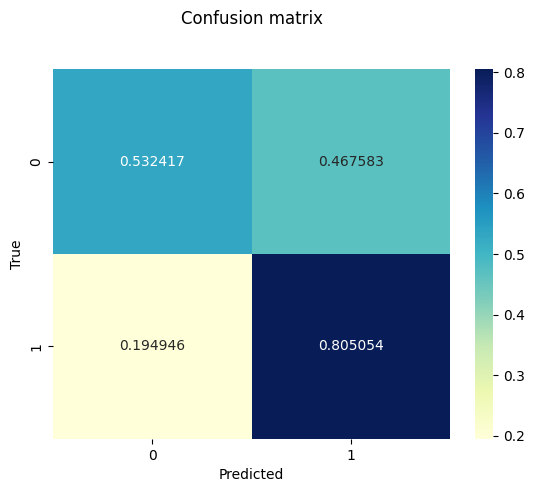

In [95]:
# classification with xgboost

from xgboost import XGBClassifier
import xgboost as xgb

model_xgb = XGBClassifier( n_estimators=100, max_depth=3, learning_rate=0.03, random_state=50)
print(score_classifier(X,model_xgb,labels,nb_splits=3))

importances = pd.DataFrame({
    'feature': df.drop(['TARGET_5Yrs','Name'],axis=1).columns,
    'importance': model_xgb.feature_importances_
})

print(importances.sort_values(by='importance', ascending=False))


# Selecting the model

In [104]:
best_model = model_SVC

print("Best model is ",best_model)

filename = 'finalized_model.sav'
pickle.dump(best_model, open(filename, 'wb'))

Best model is  SVC(C=1.9, probability=True)


# Selecting the model - decision making


J'ai choisi de retenir le modèle SVC avec un C optimal de 1.9. Le modèle a un recall score de 0.83 sur le jeu de test, soit un des meilleurs avec la régression logistique et le bagging de régression logistique. Le modèle SVC maximise le ratio True Positive / False Positive, ce qui est important pour le client (il veut minimiser le risque qu'un joueur sur lequel il a investi ne dure pas 5 ans dans la NBA).  <newline>

Notons tout de même que le modèle SVC est très sensible aux outliers, ce qui peut être problématique pour le client. En effet, si un joueur a une saison exceptionnelle, il peut être classé comme un joueur de niveau NBA, alors qu'il n'a pas encore la stabilité nécessaire pour jouer 5 ans dans la NBA. <newline>

Finalement, aucun modèle testé n'est pleinement satisfaisant (le joueur a quasiment une chance sur deux de ne pas jouer plus de 5 ans en NBA même si le modèle l'a prédit, ce qui est similaire à un tirage aléatoire). Cela peut être dû au fait que le dataset est trop petit, ou que les features ne sont pas assez représentatives du niveau d'un joueur. <newline> 

Afin d'affiner l'étude, il faudrait peut-être ajouter des features comme le nombre de matchs joués par saison, ou le nombre de points marqués par match. Il faudrait aussi peut-être ajouter des features qualitatives comme la taille du joueur, son poids, son âge, etc. <newline>



# API

Pour run l'API : <newline>
- lancer app.py <newline>
- copier le lien dans un navigateur <newline>
- remplir les champs et cliquer sur "Predict" <newline>